# Import Library

In [ ]:
import pandas as pd
import sqlite3
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt

# Extract Data

In [79]:
# From csv
electricity_access_precent = pd.read_csv('DataSource/electricity_access_precent.csv', quotechar='"')

rural_population_percent = pd.read_csv("DataSource/rural_population_percent.csv", quotechar='"')

gdp_data = pd.read_csv('DataSource/gdp_data.csv', quotechar='"')

mystery = pd.read_csv('DataSource/mystery.csv', quotechar='"')

population_data_from_csv = pd.read_csv('DataSource/population_data.csv', quotechar='"')

projects_data = pd.read_csv("DataSource/projects_data.csv", quotechar='"')


# From json
population_data_from_json = pd.read_json('DataSource/population_data.json')


# From db
conn = sqlite3.connect('DataSource/population_data.db')
population_data_from_db = pd.read_sql_query("SELECT * FROM population_data;", conn)
conn.close()


# From xml
with open("DataSource/population_data.xml", "r") as f:
    xml_data = f.read()

soup = BeautifulSoup(xml_data, "xml")
data = []
for record in soup.find_all("record"):
    record_data = {}
    for field in record.find_all("field"):
        name = field.get("name")
        value = field.text
        key = field.get("key")  # Get the key attribute
        record_data[name] = value
        if name != "Year" and name != "Value":  # Skip adding key for Year and Value fields
            record_data[name+"_key"] = key  # Add the key attribute to the record data except for Year and Value
    data.append(record_data)

population_data_from_xml = pd.DataFrame(data)


# from API
all_iso2codes = []

url = "https://api.worldbank.org/v2/countries/"
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, "xml")
    total_pages = int(soup.find('wb:countries')['pages'])
    for page_num in range(1, total_pages + 1):
        url = f"https://api.worldbank.org/v2/countries/?page={page_num}"
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "xml")
            countries = soup.find_all('wb:country')
            iso2codes = [country.find('wb:iso2Code').text for country in countries]
            all_iso2codes.extend(iso2codes)
        else:
            print("Error:", response.status_code)
else:
    print("Error:", response.status_code)

iso2codes_combined = ";".join(all_iso2codes)

url = f"https://api.worldbank.org/v2/countries/{iso2codes_combined}/indicators/SP.POP.TOTL/?format=json&per_page=1000"
data = []
page = 1
total_pages = None

while total_pages is None or page <= total_pages:
    response = requests.get(url, params={"page": page})
    response_data = response.json()
    if total_pages is None:
        total_pages = response_data[0]['pages']
    data.extend(response_data[1])
    page += 1

df_worldbank = pd.json_normalize(data)

C:\Users\SINTA\AppData\Local\Temp\ipykernel_160\2481610544.py:12: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  projects_data = pd.read_csv("DataSource/projects_data.csv", quotechar='"')


# Transfrom

#### - Check Duplicate

In [ ]:
duplicate_rows = electricity_access_precent[projects_data.duplicated(keep=False)]
print(duplicate_rows)

duplicate_rows = gdp_data[projects_data.duplicated(keep=False)]
print(duplicate_rows)

duplicate_rows = mystery[projects_data.duplicated(keep=False)]
print(duplicate_rows)

duplicate_rows = population_data_from_csv[projects_data.duplicated(keep=False)]
print(duplicate_rows)

duplicate_rows = population_data_from_db[projects_data.duplicated(keep=False)]
print(duplicate_rows)

duplicate_rows = population_data_from_json[projects_data.duplicated(keep=False)]
print(duplicate_rows)

duplicate_rows = population_data_from_xml[projects_data.duplicated(keep=False)]
print(duplicate_rows)

duplicate_rows = projects_data[projects_data.duplicated(keep=False)]
print(duplicate_rows)

duplicate_rows = rural_population_percent[projects_data.duplicated(keep=False)]
print(duplicate_rows)

duplicate_rows = df_worldbank[projects_data.duplicated(keep=False)]
print(duplicate_rows)

### - Handle Missing Value

In [64]:
def handle_missing_value_by_column(data):
    total_row = len(data)
    missing_values = data.isnull().sum()
    missing_percentage = (missing_values / (missing_values + total_row)) * 100
    columns_to_drop = missing_percentage[missing_percentage > 20].index
    data.drop(columns=columns_to_drop, inplace=True)
    return data
                

def handle_missing_value_by_row(data, column_param) :
    index = data.columns.get_loc(column_param) ## ambil index dari kolom pembatas
    cek_kolom = data.columns[index + 1:]
    jumlah_cek_kolom = len(cek_kolom)
    drop_rows = []
    for index, row in data.iterrows() :
        missing_values = row[cek_kolom].isna() | (row[cek_kolom]==0)
        if missing_values.any() :
            missing_values_count = missing_values.sum()
            missing_percent = (missing_values_count/jumlah_cek_kolom)*100
            if missing_percent > 20 :
                drop_rows.append(index)
            else:
                row[cek_kolom] = row[cek_kolom].replace(0, pd.NA)
                numeric_row = row[cek_kolom].apply(pd.to_numeric, errors='coerce')
                mean_row = numeric_row.mean()
                data.loc[index, cek_kolom] = numeric_row.fillna(mean_row)

    data.drop(index=drop_rows, inplace=True)
    return data

##### 1. electricity_access_percent

In [65]:
handle_missing_value_by_column(electricity_access_precent)
handle_missing_value_by_row(electricity_access_precent, 'Indicator Code')
df = electricity_access_precent
df = df.rename(columns={'Country Name':'country_name','Country Code':'country_code', 'Indicator Name':'indicator_name','Indicator Code':'indicator_code'})
df = df.melt(id_vars=["country_name","country_code","indicator_name","indicator_code"], var_name='year', value_name='electricity_access_percent')
df = df.sort_values(by='country_name')
electricity_access_precent=df
electricity_access_precent

,country_name,country_code,indicator_name,indicator_code,year,electricity_access_percent
1537,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,1996,0.010000
2049,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,1998,0.021977
6401,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,2015,71.500000
2817,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,2001,0.776537
5889,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,2013,67.259552
...,...,...,...,...,...,...
3071,Zimbabwe,ZWE,Access to electricity (% of population),EG.ELC.ACCS.ZS,2001,33.830868
2559,Zimbabwe,ZWE,Access to electricity (% of population),EG.ELC.ACCS.ZS,1999,38.400000
6399,Zimbabwe,ZWE,Access to electricity (% of population),EG.ELC.ACCS.ZS,2014,32.300000
4351,Zimbabwe,ZWE,Access to electricity (% of population),EG.ELC.ACCS.ZS,2006,37.200000


##### 2. rural_population_percent

In [66]:
handle_missing_value_by_column(rural_population_percent)
handle_missing_value_by_row(rural_population_percent, 'Indicator Code')
df = rural_population_percent
df = df.rename(columns={'Country Name':'country_name','Country Code':'country_code', 'Indicator Name':'indicator_name','Indicator Code':'indicator_code'})
df = df.melt(id_vars=["country_name","country_code","indicator_name","indicator_code"], var_name='year', value_name='rural_population_percent')
df = df.sort_values(by='country_name')
rural_population_percent=df
rural_population_percent

,country_name,country_code,indicator_name,indicator_code,year,rural_population_percent
4501,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,1978,85.042
12751,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,2011,74.926
10751,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,2003,77.763
4751,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,1979,84.565
501,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,1962,91.195
...,...,...,...,...,...,...
8249,Zimbabwe,ZWE,Rural population (% of total population),SP.RUR.TOTL.ZS,1992,69.501
7999,Zimbabwe,ZWE,Rural population (% of total population),SP.RUR.TOTL.ZS,1991,70.262
7749,Zimbabwe,ZWE,Rural population (% of total population),SP.RUR.TOTL.ZS,1990,71.012
6999,Zimbabwe,ZWE,Rural population (% of total population),SP.RUR.TOTL.ZS,1987,73.191


##### 3. All Population Data

In [67]:
# csv
handle_missing_value_by_column(population_data_from_csv)
handle_missing_value_by_row(population_data_from_csv,'Indicator Code')
df = population_data_from_csv
df['Indicator Name'] = df['Indicator Name'].str.replace('Population, total', 'Population total')
df = df.rename(columns={"Country Name":"country_name","Country Code":"country_code","Indicator Name":"indicator_name","Indicator Code":"indicator_code"})
df = df.melt(id_vars=["country_name","country_code","indicator_name","indicator_code"], var_name='year', value_name='population')
df = df.sort_values(by='country_name')
population_data_from_csv = df

# json
handle_missing_value_by_column(population_data_from_json)
handle_missing_value_by_row(population_data_from_json,'Indicator Code')
df = population_data_from_json
df['Indicator Name'] = df['Indicator Name'].str.replace('Population, total', 'Population total')
df = df.rename(columns={"Country Name":"country_name","Country Code":"country_code","Indicator Name":"indicator_name","Indicator Code":"indicator_code"})
df = df.melt(id_vars=["country_name","country_code","indicator_name","indicator_code"], var_name='year', value_name='population')
df = df.sort_values(by='country_name')
population_data_from_json = df

# db
handle_missing_value_by_column(population_data_from_db)
handle_missing_value_by_row(population_data_from_db,'Indicator_Code')
df = population_data_from_db
df['Indicator_Name'] = df['Indicator_Name'].str.replace('Population, total', 'Population total')
df = df.rename(columns={"Country_Name":"country_name","Country_Code":"country_code","Indicator_Name":"indicator_name","Indicator_Code":"indicator_code"})
df = df.melt(id_vars=["country_name","country_code","indicator_name","indicator_code"], var_name='year', value_name='population')
df = df.sort_values(by='country_name')
population_data_from_db = df

# xml
df = population_data_from_xml
df['Item'] = df['Item'].str.replace('Population, total', 'Population total')
df = df.rename(columns={"Country or Area":"country_name","Country or Area_key":"country_code","Item":"indicator_name","Item_key":"indicator_code", "Year":"year","Value": "population"})
population_data_from_xml = df


#### 4. gdp_data

In [80]:
handle_missing_value_by_column(gdp_data)
handle_missing_value_by_row(gdp_data, 'Indicator Code')
df = gdp_data
df = df.rename(columns={"Country Name":"country_name","Country Code":"country_code","Indicator Name":"indicator_name","Indicator Code":"indicator_code"})
df = df.melt(id_vars=["country_name","country_code","indicator_name","indicator_code"], var_name='year', value_name='current_usd')
df = df.sort_values(by='country_name')
gdp_data = df
gdp_data


#### 5. mystery

In [82]:
handle_missing_value_by_column(mystery)
handle_missing_value_by_row(population_data_from_csv,'Indicator Code')
df = population_data_from_csv
df['Indicator Name'] = df['Indicator Name'].str.replace('Population, total', 'Population total')
df = df.rename(columns={"Country Name":"country_name","Country Code":"country_code","Indicator Name":"indicator_name","Indicator Code":"indicator_code"})
df = df.melt(id_vars=["country_name","country_code","indicator_name","indicator_code"], var_name='year', value_name='population')
df = df.sort_values(by='country_name')
mystery = df
mystery

,country_name,country_code,indicator_name,indicator_code,year,population
9621,Afghanistan,AFG,Population total,SP.POP.TOTL,1997,1.838160e+07
5461,Afghanistan,AFG,Population total,SP.POP.TOTL,1981,1.305395e+07
1041,Afghanistan,AFG,Population total,SP.POP.TOTL,1964,9.731361e+06
10661,Afghanistan,AFG,Population total,SP.POP.TOTL,2001,2.096646e+07
781,Afghanistan,AFG,Population total,SP.POP.TOTL,1963,9.533954e+06
...,...,...,...,...,...,...
8579,Zimbabwe,ZWE,Population total,SP.POP.TOTL,1992,1.068287e+07
1299,Zimbabwe,ZWE,Population total,SP.POP.TOTL,1964,4.269863e+06
5979,Zimbabwe,ZWE,Population total,SP.POP.TOTL,1982,7.721536e+06
2599,Zimbabwe,ZWE,Population total,SP.POP.TOTL,1969,5.009514e+06


#### 6. projects_data

In [ ]:
## soon

<Axes: ylabel='population'>

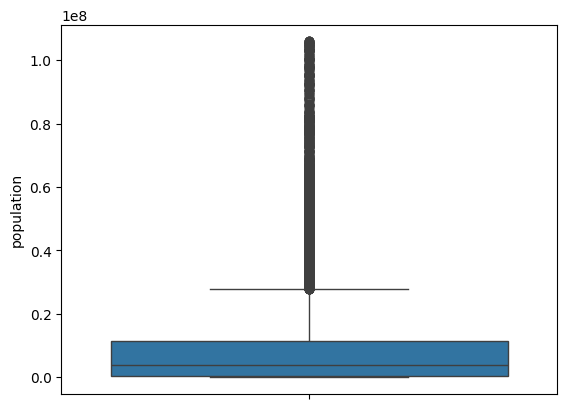

In [75]:
# population_data_from_json
# df = population_data_from_csv.sort_values(by='population')
sns.boxplot(df['population'])

In [74]:
df = population_data_from_csv
# data_sorted = data.sort_values(by='population')
df = df.sort_values(by='population')
Q1 = df['population'].quantile(0.25)
Q3 = df['population'].quantile(0.75)
IQR = Q3 - Q1

# Tentukan Batas Bawah dan Batas Atas
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

# Identifikasi outliers
outliers = df[(df['population'] < lower_bound) | (df['population'] > upper_bound)]

# Hapus outliers dari DataFrame
df = df.drop(outliers.index)

# print("DataFrame without outliers:")
# print(df)
df

,country_name,country_code,indicator_name,indicator_code,year,population
144,St. Martin (French part),MAF,Population total,SP.POP.TOTL,1960,4279.0
176,Nauru,NRU,Population total,SP.POP.TOTL,1960,4433.0
404,St. Martin (French part),MAF,Population total,SP.POP.TOTL,1961,4453.0
664,St. Martin (French part),MAF,Population total,SP.POP.TOTL,1962,4566.0
924,St. Martin (French part),MAF,Population total,SP.POP.TOTL,1963,4656.0
...,...,...,...,...,...,...
11994,Central Europe and the Baltics,CEB,Population total,SP.POP.TOTL,2006,105901322.0
1924,Indonesia,IDN,Population total,SP.POP.TOTL,1967,105907403.0
938,Middle East & North Africa (excluding high inc...,MNA,Population total,SP.POP.TOTL,1963,105914391.0
1012,Middle East & North Africa (IDA & IBRD countries),TMN,Population total,SP.POP.TOTL,1963,105914391.0


In [ ]:
# df_cleaned.to_csv("tessss.csv")

# sns.boxplot(df_cleaned['population'])
population_data_from_xml
# population_data_from_csv

In [ ]:
df = population_data_from_xml
df = df.rename(columns={"Country or Area":"country_name","Country or Area_key":"country_code","Item":"indicator_name","Item_key":"indicator_code", "Value": "population"})
population_data_from_xml


In [ ]:
# print(electricity_access_precent.encoding)
# population_data_from_xml.to_csv("HHHH.csv")
# population_data_from_db
# electricity_access_precent.info()

with open("DataSource/population_data.xml", "r") as f:
    xml_data = f.read()

soup = BeautifulSoup(xml_data, "xml")
data = []
for record in soup.find_all("record"):
    record_data = {}
    for field in record.find_all("field"):
        name = field.get("name")
        value = field.text
        key = field.get("key")  # Get the key attribute
        record_data[name] = value
        if name != "Year" and name != "Value":  # Skip adding key for Year and Value fields
            record_data[name+"_key"] = key  # Add the key attribute to the record data except for Year and Value
    data.append(record_data)

population_data_from_xml = pd.DataFrame(data)



#### - Cleaning data electricity_access_percent & rural_population_percent

In [ ]:
# ### cleaning rural_population_percent
# df = rural_population_percent
# index_indicator_code = df.columns.get_loc('Indicator Code')
# column_after_index = df.columns[index_indicator_code + 1:]
# empty_row = df[df[column_after_index].isnull().all(axis=1)]
# delete_country_names = empty_row.loc[:, 'Country Name'].tolist()
# print(delete_country_names)
# df = df.drop(empty_row.index)

# df.drop(columns=["Unnamed: 62"], inplace=True)
# df = df.fillna(0.000)
# df.drop(columns=["Indicator Name","Indicator Code"], inplace=True)
# df = df.rename(columns={'Country Name':'country_name','Country Code':'country_code'})
# df = df.melt(id_vars=["country_name","country_code"], var_name='year', value_name='rural_population_percent')
# rural_population_percent=df

# ### cleaning electricity_access_percent
# df = electricity_access_precent
# for country_name in delete_country_names:
#     df = df[df['Country Name'] != country_name]
    
# df.drop(columns=["Unnamed: 62"], inplace=True)
# df = df.fillna(0.000)
# df.drop(columns=["Indicator Name","Indicator Code"], inplace=True)
# df = df.rename(columns={'Country Name':'country_name','Country Code':'country_code'})
# df = df.melt(id_vars=["country_name","country_code"], var_name='year', value_name='electricity_access_percent')
# electricity_access_precent = df

#### - Merge electricity_access_percent & rural_population_percent

In [ ]:
combine_electricity_rural = pd.merge(rural_population_percent,electricity_access_precent, how='left', on=["country_name", "country_code", "year"])
combine_electricity_rural

#### - Cleaning all data population (csv,json,db,xml)

In [ ]:
combine_electricity_rural.to_csv("tes.csv")

In [ ]:
all_iso2codes = []

url = "https://api.worldbank.org/v2/countries/"
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, "xml")
    total_pages = int(soup.find('wb:countries')['pages'])
    for page_num in range(1, total_pages + 1):
        url = f"https://api.worldbank.org/v2/countries/?page={page_num}"
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "xml")
            countries = soup.find_all('wb:country')
            iso2codes = [country.find('wb:iso2Code').text for country in countries]
            all_iso2codes.extend(iso2codes)
        else:
            print("Error:", response.status_code)
else:
    print("Error:", response.status_code)

iso2codes_combined = ";".join(all_iso2codes)
# print(iso2codes_combined)

url = f"https://api.worldbank.org/v2/countries/{iso2codes_combined}/indicators/SP.POP.TOTL/?format=json&per_page=1000"
data = []
page = 1
total_pages = None

while total_pages is None or page <= total_pages:
    response = requests.get(url, params={"page": page})
    response_data = response.json()
    if total_pages is None:
        total_pages = response_data[0]['pages']
    data.extend(response_data[1])
    page += 1

df_worldbank = pd.json_normalize(data)
df_worldbank